## BTVN Tuần 1: 17/2
## Giải thích Bước 1, Bước 2 Phần 7 (Backpropagation)

### Bước 1: Tính gradient của hàm mất mát theo đầu ra

Ở bước này, ta đo mức độ sai khác giữa giá trị dự đoán $\hat{y}$ và giá trị thật $y$.  
Thông qua hàm mất mát (ví dụ Binary Cross-Entropy), ta tính đạo hàm:

$$
\frac{\partial L}{\partial \hat{y}}
$$

Ý nghĩa:
- Cho biết nếu thay đổi dự đoán một lượng nhỏ thì mất mát thay đổi bao nhiêu  
- Đây là tín hiệu lỗi ban đầu để lan truyền ngược trong mạng  

Nói đơn giản: bước này xác định mức độ sai của dự đoán.

---

### Bước 2: Lan truyền lỗi về lớp trước bằng quy tắc chuỗi

Sau khi có gradient ở đầu ra, ta cần biết lỗi này ảnh hưởng thế nào đến các giá trị bên trong mạng.  
Ta dùng quy tắc chuỗi (chain rule):

$$
\frac{\partial L}{\partial z}
=
\frac{\partial L}{\partial \hat{y}}
\cdot
\frac{\partial \hat{y}}{\partial z}
$$

Với hàm kích hoạt Sigmoid:

$$
\frac{\partial \hat{y}}{\partial z} = \hat{y}(1-\hat{y})
$$

Ý nghĩa:
- Chuyển lỗi từ đầu ra về trước hàm kích hoạt  
- Chuẩn bị để tính gradient theo trọng số và bias  

bước này xác định lỗi ảnh hưởng đến neuron trước đó như thế nào.

---

## Tóm tắt

- Bước 1: Tính mức độ sai của dự đoán  
- Bước 2: Lan truyền sai số về các lớp trước bằng đạo hàm  
- Đây là nền tảng để cập nhật trọng số giúp mô hình học tốt hơn


## BTVN tuần 2:

Thử trên tập dữ liệu MNIST (có sẵn trong thư mục data/MNIST/raw). Mã dưới đây sẽ đọc file idx gốc, xây một mô hình PyTorch nhỏ, huấn luyện và đánh giá.

## BTVN 2:
#### -thử trên tập data MNIStT và cat and dog
#### -Deadline 6/3
#### -nhưng phải làm theo cấu trúc của thầy,
#### -Dùng torch

In [8]:
import struct
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def load_idx_images(path):
    with open(path, 'rb') as f:
        magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
        data = np.frombuffer(f.read(), dtype=np.uint8)
        data = data.reshape(num, rows, cols)
    return data

def load_idx_labels(path):
    with open(path, 'rb') as f:
        magic, num = struct.unpack('>II', f.read(8))
        data = np.frombuffer(f.read(), dtype=np.uint8)
    return data

# Paths (tùy theo workspace của bạn)
train_images_path = 'data/MNIST/raw/train-images-idx3-ubyte'
train_labels_path = 'data/MNIST/raw/train-labels-idx1-ubyte'
test_images_path = 'data/MNIST/raw/t10k-images-idx3-ubyte'
test_labels_path = 'data/MNIST/raw/t10k-labels-idx1-ubyte'

X_train = load_idx_images(train_images_path)
y_train = load_idx_labels(train_labels_path)
X_test = load_idx_images(test_images_path)
y_test = load_idx_labels(test_labels_path)

# To tensors and normalize
X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1) / 255.0
X_test_t = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1) / 255.0
y_train_t = torch.tensor(y_train, dtype=torch.long)
y_test_t = torch.tensor(y_test, dtype=torch.long)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

print('Loaded MNIST:', X_train_t.shape, y_train_t.shape, X_test_t.shape, y_test_t.shape)

Loaded MNIST: torch.Size([60000, 1, 28, 28]) torch.Size([60000]) torch.Size([10000, 1, 28, 28]) torch.Size([10000])


In [9]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(32*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.net(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

def evaluate(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            pred = out.argmax(dim=1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)
    return correct/total

# Quick training loop (few epochs)
epochs = 3
for ep in range(epochs):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    train_acc = evaluate(train_loader)
    test_acc = evaluate(test_loader)
    print(f'Epoch {ep+1}/{epochs} - loss: {running_loss/len(train_ds):.4f} - train_acc: {train_acc:.4f} - test_acc: {test_acc:.4f}')

Epoch 1/3 - loss: 0.3001 - train_acc: 0.9733 - test_acc: 0.9745
Epoch 2/3 - loss: 0.0698 - train_acc: 0.9756 - test_acc: 0.9779
Epoch 3/3 - loss: 0.0494 - train_acc: 0.9877 - test_acc: 0.9852


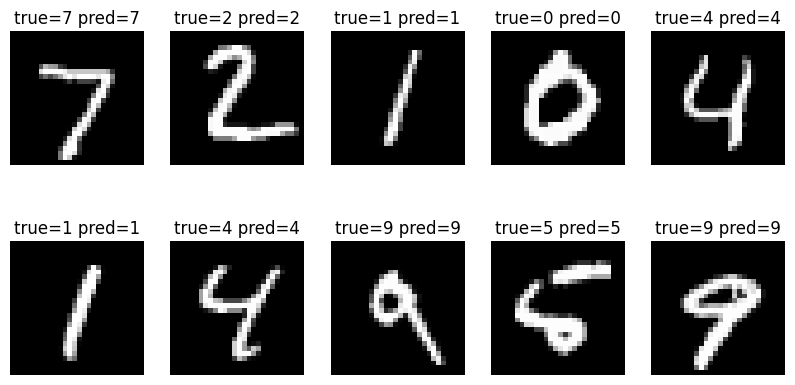

In [10]:
# Show some test samples and predictions
model.eval()
xb, yb = next(iter(test_loader))
xb = xb.to(device)
with torch.no_grad():
    preds = model(xb).argmax(dim=1).cpu().numpy()
xb = xb.cpu().numpy()
fig, axes = plt.subplots(2,5, figsize=(10,5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(xb[i,0], cmap='gray')
    ax.set_title(f'true={int(yb[i])} pred={int(preds[i])}')
    ax.axis('off')
plt.show()